# 4.3 Blob detection and description

Now, we are going to deal with another type of keypoints. Corners and edges were already covered, so it is time for **blobs**!  

Roughly speaking, a blob is a group of connected pixels in an image in which some properties are constant or approximately constant (e.g. their intensities). All the pixels in a blob can be considered in some sense to be similar to each other. Blobs provide complementary information about regions which is not obtained from edges or corners.

<img src="./images/blob.png" width="400"/><center><i>Examples of blobs</i>$\\[5pt]$

The **S**cale-**I**nvariant **F**eature **T**ransform (**SIFT**) is a blob detection and description algorithm whose implementation is far more complex than the Harris detector but easier to use in openCV. In this notebook we will take a look at the main steps involved in the SIFT algorithm and how can it be implemented.

## Problem context - Image stitching

In the first notebook of this chapter the Harris corner detector and NCC were proposed to find correspondences between images in the scope of an image stitching system. However, matching keypoints through NCC is not so reliable since it is not **invariant** against typical transformations between images such as **rotation**, **scale** or change in the **point of view**. In these cases, it is really hard or even not possible to find matches between the transformed images. Besides, it has not a mechanisms to differentiate points in repetitive elements (e.g. windows in a skyscraper):$\\[10pt]$

<img src="./images/ncc_problem.jpg" width="300" align="left"/><img src="./images/skyscraper.jpg" width="300" align="rigth"/>$\\[0.5pt]$
<center><i>Some examples where the combination of the Harris detector and NCC could hardly match keypoints.</i></center>

Aiming to face these issues, in this notebook we will explore SIFT!

## 4.3.1 SIFT (Scale-Invariant Feature Transform)

SIFT was proposed (and patented) by David Lowe in 2004. It finds projections of distintive 3D points in the image, not necessary corners, and also describes them. This detector and descriptor has invariance to:

- Scale (important difference against Harris).
- Rotation.
- Illumination (partially).
- Affine transformation (partially).

Let's start by trying to understand **how the SIFT detector works**!

### Step 1: Construction of octaves

SIFT progressively blurs the input image by applying a set of Gaussian filters with a growing standard deviation. Once you have a sequence of $s$ images (i.e. a sequence of 6 blurred images in the example below), we have completed an **octave**. Then, the image resolution is reduced to half and the blurring process continues. We repeat this process until the pictures are too small to proceed$\\[5pt]$ (i.e. we pre-define a certain number of octaves):

<img src="./images/sift_octave.png" width="800"/>$\\[5pt]$

The blue arrow points to the beginning of a new octave while the green arrow indicates the process of Gaussian blurring. As you can see, in the example we have octaves of 6 images ($s = 6$) and 4 octaves (i.e. the resolution is downsampled 4 times). If we stack all the images, we say that we have built a pyramid of images:

<img src="./images/sift_dog.jpg" width="400"/>$\\[5pt]$

### Step 2: Difference of Gaussians (DoG)

For each pair of horizontally adjacent pictures in the table above, we compute the differences of the individual pixels. This way, we obtain $(s-1)$ DoG images for each octave:$\\[5pt]$

<img src="./images/octave_dog.png" width="800"/>$\\[5pt]$

The **Difference of Gaussians** (DoG) method is a different and more efficient way to implement the LoG (laplacian of Gaussian) border detector, which was covered in notebook 3.2.

### Step 3: Extreme points

Now, for detecting blobs in SIFT, we search for **extreme** points in the DoG images. For that, each pixel is compared with its **26 neighbors** (8 in the same image, 9 in the previous image in the pyramid with the same scale and 9 in the next one). An extreme point can be a maximum or a minimum, so, if the grey level of the pixel is greater or lower than all its 26 neighbors it is considered as a keypoint candidate.

*Note that this is only possible for DoG images that are not the first or the last image in that scale.*$\\[5pt]$

<img src="./images/sift_keypoints.png" width="500"/>$\\[5pt]$

Local maximum points have been plot in yellow while local minimum points are in red. An example of an extreme point can be seen next:

<img src="./images/neighbors.png" width="500"/>$\\[5pt]$

But, **why extreme points in the resulting DoG pyramid represent blobs?** Let's go back a little bit to the use of the LoG operator in edges (the DoG approach is just a more efficient way to implement the LoG operator):

<img src="./images/log_edges.png" width="600"/>$\\[5pt]$

As you can see, the response is zero at the edge but it has **a pair of ripples** around it. We did not take care of them before as we were interested in the edges, so we just focused in looking for zero-crosses of the response. But what if we have a signal like this (signal at the top, response of the LoG operator at the bottom):

<img src="./images/log_square_0.png" width="250"/>$\\[5pt]$

All the pixels in the top of the signal **form a blob**, since all of them have a constant value. If we look at the response of the LoG operator we can see that it crosses zero at the edges and also presents the mentioned ripples around such points. But, **what happens if we reduce the size of the square signal?**

<img src="./images/log_square_n.png" width="800"/>$\\[5pt]$

Well, eventually the ripples will **superimpose** and they will form a maximum or minimum (**i.e. an extreme point**) in the LoG response. Note that reducing the size of the signal is equivalent to changing the scale in which we are looking for extreme points. This means that if we search for these extreme points in all the pyramid of images (remember that they are just scaled versions of the original image) we will be able to find the blobs at a certain scale. More importantly, if in posterior images the scale changes, we still be able to find the same blob but at a different scale, so **our detector will be invariant to scale**!

### Step 4: Compute descriptors

Finally, the SIFT keypoint descriptor is computed as the **histogram of orientations** around the extreme point. So, first the orientation at each pixel in its local neighborhood is computed and inserted into a histogram, but being previously weighted by two factors:

- The magnitude of the gradient at that pixel
- The value at that pixel of a Gaussian kernel centered at the extreme point

This way we give more importance to the orientations of **those pixels closer to the candidate** and **those pixels with a higher score** (i.e. they have *stronger* orientations).

<img src="./images/sift_descriptor.png" width="800"/>$\\[5pt]$

This histogram has a pre-defined number of bins and the values of such bins of orientations will be taken as the **descriptor** of the keypoints. The mode of the histogram is also stored as the **main orientation** of the keypoint. In essence, the descriptor of the keypoint **summarizes the orientations of the pixels in its neighborhood**. This information is invariant to changes in illumination, orientation, scale and partially to changes in the view-point.

In summary, we will have three pieces of information that will completely describe the keypoint and could be used to perform keypoint matching:
- The **descriptor**, 
- the **main orientation**, 
- and the **scale** in which the extrema was found.

Of course, this has been a short explanation of the SIFT method where a lot of small details have been skipped, but we think you'll get the gist of it. If you want a fully detailed description of the algorithm, have a look to [this](http://weitz.de/sift/index.html?size=large).

## 4.3.2 Coding

As mentioned, the SIFT algorithm is patented, and **it is not included in all versions of  OpenCV**. If your OpenCV version includes an implementation of the SIFT detector, you will probably find it in the `contrib` package (a sort of third-party contributions not officially implemented in the core of the OpenCV library, but totally compatible with it). In case your version does not include such implementation, you can use **[pysift](https://github.com/rmislam/PythonSIFT)**, a third party software that implements it like an OpenCV method (only for educational purposes), returning our beloved [`cv2.KeyPoint`](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html) objects. If you choose this option, uncomment the lines in the cell below.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
images_path = './images/'

# Uncomment this if you plan to use pysift
import sys
sys.path.append("..")
from utils.third_party import pysift #https://github.com/rmislam/PythonSIFT

#### <font color="orange">Code pill</font>

If you use the OpenCV's method:
- First, create a SIFT detector with `sift = cv2.xfeatures2d.SIFT_create()`
- Then, call to the method `detectAndCompute(image,mask)`, as explained [here](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html) to find keypoints (with descriptors!)
- This function returns a list of `cv2.KeyPoint` objects and one array with shape $\left(n\_keypoints,4x4x8\right)$ that corresponds to the 128D descriptor of each keypoint.

If you use `pysift`:
- Call to the function `pysift.computeKeypointsAndDescriptors` whose only input is a grey image
- This function also returns a list of `cv2.KeyPoint` objects and one array with shape $\left(n\_keypoints,4x4x8\right)$ that corresponds to the 128D descriptor of each keypoint.

### **<span style="color:green"><b><i>ASSIGNMENT 1: Looking for SIFT keypoints</i></b></span>**

Find SIFT keypoints in the `sift_2.jpeg` image and display the image along with the keypoints.

*Notes:*
- *to draw complex keypoints (as those obtained using SIFT), you can use `flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` as a parameter in the `drawKeypoints` method*. 
- *finding SIFT keypoints is a really costly task, so it will take some time to finish.*

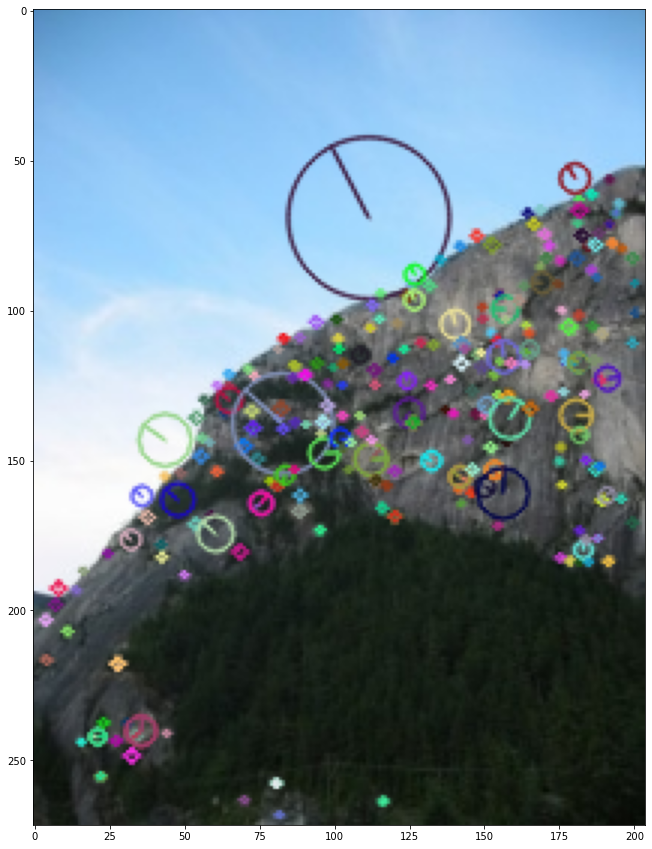

In [2]:
# ASSIGNMENT 1
# Find SIFT keypoints in 'sift_2.jpeg' image and display them using 'flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS'
# Use the grey image for finding the keypoints but display its color version.
# Write your code here!
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

# Read image
image = cv2.imread(images_path + 'sift_2.jpeg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Obtain gray image
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Compute blobs and descriptors using SIFT

# OpenCV
#sift = cv2.xfeatures2d.SIFT_create(300)
#kps, descriptors = sift.detectAndCompute(gray,None)

# pysift
kps, descriptors = pysift.computeKeypointsAndDescriptors(gray)

# Draw blobs
image_corners = np.copy(image)
cv2.drawKeypoints(image,kps,image_corners,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Use rich keypoints flag

# Show image and blobs
plt.imshow(image_corners)

You should get something like this:

<img src="./images/sift_example.png" width="300"/>

### Matching keypoints

Now, we are going to match the keypoints in two images of a mountain: `sift_1.jpeg` and `sift_2.jpeg`, which have overlapping fields.$\\[5pt]$

<img src="./images/mountain_1.jpg" width="300" align="left"/><img src="./images/mountain_2.jpg" width="300" align="rigth"/>$\\[5pt]$

*For this assignment, the images have been downsampled in order to compute keypoints faster*

**What to do?** Follow the next steps to develop a keypoint matching system using SIFT descriptors.

Similarly to what we did with the Harris method, we are going to do this step by step:

### **<span style="color:green"><b><i>ASSIGNMENT 2a: Retrieving keypoints and descriptions</i></b></span>**

**First compute the keypoints and their descriptors in each image.**

In [3]:
# ASSIGNMENT 2a
# Load the images and compute SIFT keypoints
# Write your code here!

# Read both images
image_1 = cv2.imread(images_path + 'sift_1.jpeg')
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
image_2 = cv2.imread(images_path + 'sift_2.jpeg')
image_2 = cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB)

# Get gray images
gray_1 = cv2.cvtColor(image_1,cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(image_2,cv2.COLOR_RGB2GRAY)

# Compute blobs and descriptors

# OpenCV
# sift = cv2.xfeatures2d.SIFT_create(300)
# kps_1, des_1 = sift.detectAndCompute(gray_1,None)
# kps_2, des_2 = sift.detectAndCompute(gray_2,None)

# pysift
kps_1, des_1 = pysift.computeKeypointsAndDescriptors(gray_1)
kps_2, des_2 = pysift.computeKeypointsAndDescriptors(gray_2)

### **<span style="color:green"><b><i>ASSIGNMENT 2b: Finding matches between keypoints</i></b></span>**

*Note: When you match keypoints, you are actually matching their descriptors.*

Use `cv2.BFMatcher().knnMatch()` [(documentation)](https://docs.opencv.org/3.4/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89) to obtain the list of matches, then **print the distances with the two closest candidates of the first match**.

Remember when we used the Brute-Force matcher for the ORB keypoints? Now we are going one step further and use a `knnMatch` ($K$-Nearest Neighbors). This will also return a list of the best $K$ matches but looking for them more *efficiently*. If we use $K=2$ we will get two matches for each keypoint: the two nearests matches. So, we will get a $N \times 2$ list of matches where each row represents a matched keypoint in the left image and the two columns have the information about the match with the right keypoint:

<img src="./images/sift_matching.png" width="400"/>

The distance between two descriptors is given at `DMatch.distance`. **If the distance is very low, then the keypoints are quite similar!** This is the case of keypoints 91 and 94 in the figure above.

In [4]:
# ASSIGNMENT 2b
# Use 'knnMatch' to find matches and print the distances between the first keypoint in the first image and the two most similar in the second one.
# Write your code here!

# Call knnMatch
matches = cv2.BFMatcher().knnMatch(des_1,des_2, k=2)

# Print first match distances
print(matches[0][0].distance, matches[0][1].distance)

315.7704772949219 363.8131408691406


### **<span style="color:green"><b><i>ASSIGNMENT 2c: Filtering non-robust matches</i></b></span>**

In order to discard incorrect matches, we are going to use the distance value for the two output matches that we have found for each keypoint. Thus, we will only accept matches that hasn't got two close solutions (i.e. with similar distance), because that would mean that, for a certain keypoint in one image, there are two different keypoints that are very similar to it (in terms of descriptor distance). In this situation, it is advisable to discard the match, as a wrong match (usually called **outlier**) can severely affect the robustness of any feature-based computer vision system. 

This is the case of the keypoint 1 in the previous image. There you can see that it has a distance of 17.7 to keypoint 4 and of 21.4 to keypoint 9, and those values are **too close to ensure a correct match**. In this case, it is safer to discard the match. On the contrary, keypoint 91 has a distance of 9.6 to its first match and of 87.5 to keypoint 90, so it can be safely considered a right match. 

Now, iterate along the matches list and filter those that does not fulfil the specified condition (define a certain threshold to discard wrong matches).

In [5]:
# ASSIGNMENT 2c
# Iterate over the matches and select those that seems to be robust matches.
# Write your code here!

good = []
# For each match
for m,n in matches:
    # If first two distances are not close
    if m.distance < 0.75*n.distance:
        # It is a good match! Add it to the list
        good.append(m)

### **<span style="color:green"><b><i>ASSIGNMENT 2d: Displaying the images drawing the computed (and filtered) matches</i></b></span>**

*Remember to use `flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`*

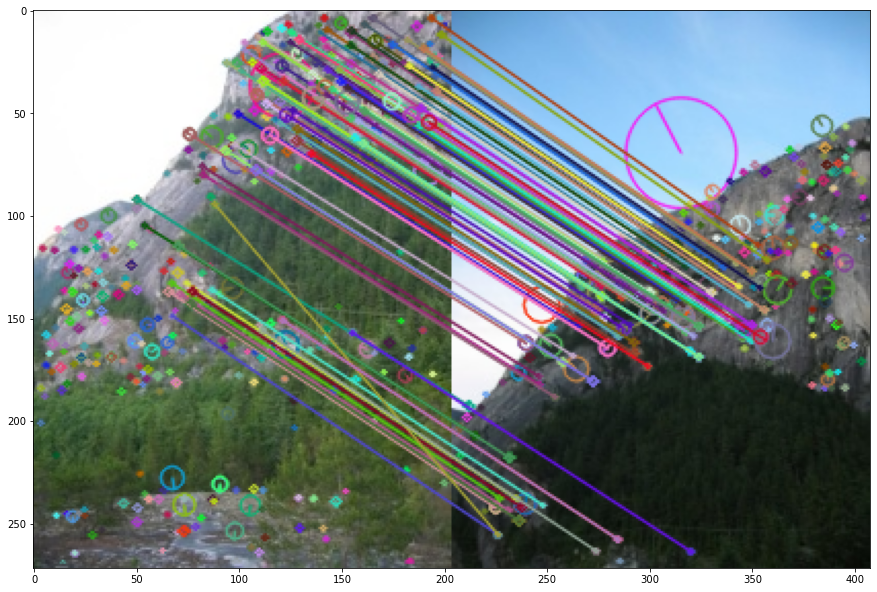

In [6]:
# ASSIGNMENT 2d
# Display the image and the matches with 'flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS'
# Write your code here!

# Draw matches
image_matches = np.copy(image_1)
image_matches = cv2.drawMatches(image_1,kps_1,image_2,kps_2,good,image_matches, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# And finally show them
plt.imshow(image_matches)

You should get something like this:

<img src="./images/sift_matching_result.png" width="600"/>

### <font color="blue"><b><i>Thinking about it</i></b></font>

**Finally, answer the following questions**

- Looking at the results, could a system stitch both images?  

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
  
- How do you think it could be done?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

## Conclusion

This notebook has presented one of the most famous keypoint detector and descriptor and you have been able to play a little bit with it. SIFT is one of the **best algorithms for feature description** and it is robust against changes in light conditions, scale, rotation and partially to changes in viewpoint. Therefore, in an artificial perception course, learning how it was acomplished and how it works is mandatory. 

However, as the SIFT algorithm is patented, some efficient alternatives have been developed in OpenCV like the [SURF](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html) method. Take a look at it!

### Extra

If you want to learn more about SIFT, you can look through the [original paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwi7y_G-xrDoAhUGHcAKHWn1DIsQFjAAegQIBRAB&url=https%3A%2F%2Fwww.cs.ubc.ca%2F~lowe%2Fpapers%2Fijcv04.pdf&usg=AOvVaw0cBGKtFZfTh8Vf_Y4kP3LS) by David Lowe. It was proposed in 1999 and published in 2004.